In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

# We will be solving the burger's equation using the Rancic method. 

In [2]:
# Parameters
T = 100
dt = 1

In [3]:
x_coordinates = np.array([x for x in range(-50, 51)])
initial_distribution = 0.2*np.exp(-(x_coordinates**2)/100) + 0.5

grid = np.zeros((T, len(x_coordinates)))
grid[0, :] = initial_distribution

In [86]:
# finite difference differentiator 
def finite_diff(row):
    diff_mat = (np.roll(row, -1) - np.roll(row, 1))/2
    return diff_mat

def two_step_vel(neg_1_row, neg_2_row):
    vel_row = (3/2)*neg_1_row - (1/2)*neg_2_row
    return vel_row

def three_step_vel(neg_1_row, neg_2_row, neg_3_row):
    vel_row = (15/8)*neg_1_row - (10/8)*neg_2_row + (3/8)*neg_3_row
    return vel_row

def velocity_function(argument, n_step_vel):
    n_step_acc = finite_diff(n_step_vel)
    n_step_jerk = finite_diff(n_step_acc)
    arg = np.floor(argument).astype(int)%len(n_step_vel)
    return n_step_vel[arg] + (argument - np.floor(argument))*n_step_acc[arg] + 0.5*(argument - np.floor(argument))**2*n_step_jerk[arg]

def find_alpha_hybrid(n_step_vel, x, a, b, tolerance = 10**(-2), max_iter = 10000):
    def f(alpha):
        return alpha - velocity_function(x - alpha, n_step_vel)
    
    for i in range(max_iter):
        c = (a + b)/2
        fc = f(c)
        if np.abs(fc)/np.abs(c) < tolerance:
            return c
        elif f(a)*fc < 0:
            b = c
        else:
            a = c

        if i%5 == 0 and i != 0:
            secant = c - fc*(c - a)/(fc - f(a))
            if a < secant < b:
                fs = f(secant)
                if abs(fs) / abs(secant) < tolerance:
                    return secant
                if fs * fc < 0:
                    a, b = c, secant
                else:
                    a, b = secant, c
        
        print(f"Iteration {i}: Alpha = {c} and diff = {fc}")

def alpha_iter(n_step_vel, tolerance = 10**(-2), max_iter = 10000):
    alpha_list = np.zeros(len(n_step_vel))
    alpha_check = np.linspace(np.min(n_step_vel), np.max(n_step_vel), 1000)
    for x in range(len(n_step_vel)):
        alpha_contender = alpha_check[0]
        prev_value = velocity_function(x - alpha_contender, n_step_vel) - alpha_contender
        for alpha in alpha_check[1:]:
            current_value = velocity_function(x - alpha, n_step_vel) - alpha
            if prev_value * current_value <= 0:
                alpha_contender = alpha
                break
            prev_value = current_value
        alpha_list[x] = alpha_contender

        # alpha_upper, alpha_lower = np.max(n_step_vel), np.min(n_step_vel)
        # for i in range(max_iter):
        #     alpha = (alpha_upper + alpha_lower)/2
        #     arg = np.floor(x - alpha).astype(int)%len(n_step_vel)
        #     func = n_step_vel[arg] + (x - alpha - np.floor(x - alpha))*n_step_acc[arg] + 0.5*(x - alpha - np.floor(x - alpha))**2*n_step_jerk[arg]
        #     if np.abs(func - alpha) < tolerance:
        #         alpha_list[x] = alpha
        #         break
            
        #     arg_lower = np.floor(x - alpha_lower).astype(int)%len(n_step_vel)
        #     func_lower = n_step_vel[arg_lower] + (x - alpha_lower - np.floor(x - alpha_lower))*n_step_acc[arg_lower] + 0.5*(x - alpha_lower - np.floor(x - alpha_lower))**2*n_step_jerk[arg_lower]
        #     if (alpha - func)*(alpha_lower - func_lower) < 0:
        #         alpha_upper = alpha
        #     else:
        #         alpha_lower = alpha
            
        #     if x == 98:
        #         print(f"alpha is {alpha} and diff is {(func - alpha)}")
        # for i in range(max_iter):
        #     arg = np.floor(x - alpha_prev).astype(int)%len(n_step_vel)
        # #    alpha_new = (1 + np.floor(x - alpha_prev) - (x - alpha_prev))*n_step_vel[np.floor(x - alpha_prev).astype(int)%len(n_step_vel)] + ((x - alpha_prev) - np.floor(x - alpha_prev))*n_step_vel[np.ceil(x - alpha_prev).astype(int)%len(n_step_vel)]
        #     alpha_new = n_step_vel[arg] + (x - alpha_prev - np.floor(x - alpha_prev))*n_step_acc[arg] + 0.5*(x - alpha_prev - np.floor(x - alpha_prev))**2*n_step_jerk[arg]
            
        #     alpha_new = alpha_prev + damping*(alpha_new - alpha_prev)

        #     if i > 2:
        #         if np.abs(alpha_new - alpha_prev) > diff:
        #             alpha_new = (alpha_prev + alpha_new)/2
        #             diff = np.abs(alpha_new - alpha_prev)
        #     elif i == 2:
        #         diff = np.abs(alpha_new - alpha_prev)

        #     if np.abs(alpha_new - alpha_prev) < tolerance:
        #         alpha[x] = alpha_new
        #         break
            
        #     alpha_prev = alpha_new
        #     if x == 98:
        #         print(alpha_new)
    return alpha_list

In [88]:
def vel_function(argument, n_step_vel):
    arg_floor = np.floor(argument).astype(int)%len(n_step_vel)
    arg_ceil = np.ceil(argument).astype(int)%len(n_step_vel)
    return n_step_vel[arg_floor] + (argument - arg_floor)*(n_step_vel[arg_ceil] - n_step_vel[arg_floor])

def alph_iter(n_step_vel, tolerance = 10**(-2), max_iter = 10000):
    alpha_list = np.zeros(len(n_step_vel))
    alpha_check = np.linspace(np.min(n_step_vel), np.max(n_step_vel), 1000)
    for x in range(len(n_step_vel)):
        alpha_contender = alpha_check[0]
        prev_value = vel_function(x - alpha_contender, n_step_vel) - alpha_contender
        for alpha in alpha_check[1:]:
            current_value = vel_function(x - alpha, n_step_vel) - alpha
            if prev_value * current_value <= 0:
                alpha_contender = alpha
                break
            prev_value = current_value
        alpha_list[x] = alpha_contender
    return alpha_list

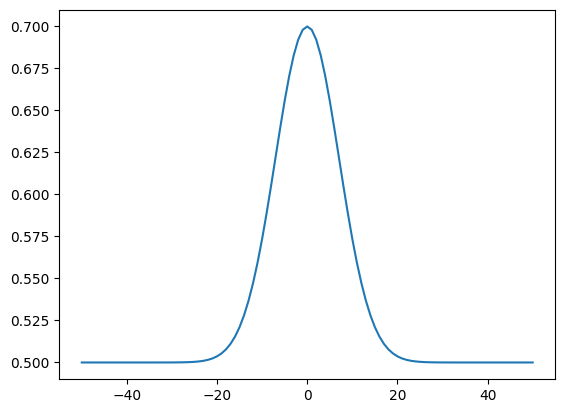

In [32]:
plt.plot(x_coordinates, grid[0, :])
plt.show()

0.5197638890544293
0.5219598767252946


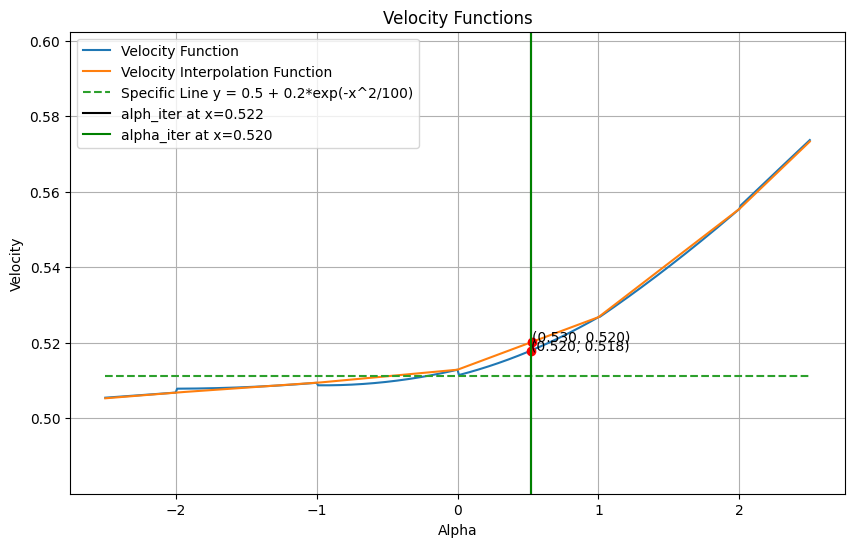

In [109]:
alpha = [a*0.01 for a in range(-250, 251)]
function_1, function_2 = [], []
x = (len(x_coordinates)-1)/2 + 17
t = 14
for a in alpha:
    function_1.append(velocity_function(x - a, three_step_vel(grid[t-1, :], grid[t-2, :], grid[t-3, :])))
    function_2.append(vel_function(x - a, three_step_vel(grid[t-1, :], grid[t-2, :], grid[t-3, :])))

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(alpha, function_1, label="Velocity Function")
plt.plot(alpha, function_2, label="Velocity Interpolation Function")

# Find intersection points and label them
for i in range(1, len(alpha)):
    if (function_1[i-1] - alpha[i-1]) * (function_1[i] - alpha[i]) <= 0:
        plt.plot(alpha[i], function_1[i], 'ro')  # Mark intersection on graph
        plt.text(alpha[i], function_1[i], f'({alpha[i]:.3f}, {function_1[i]:.3f})')  # Label intersection point
    if (function_2[i-1] - alpha[i-1]) * (function_2[i] - alpha[i]) <= 0:
        plt.plot(alpha[i], function_2[i], 'ro')  # Mark intersection on graph
        plt.text(alpha[i], function_2[i], f'({alpha[i]:.3f}, {function_2[i]:.3f})')  # Label intersection point

min_val = min(min(function_1), min(function_2))
max_val = max(max(function_1), max(function_2))
plt.ylim(bottom=min_val * 0.95, top=max_val * 1.05)

# Plotting the specific line as per the instruction
y_line = [0.5 + 0.2*np.exp(-(x-50)**2/100) for a in alpha]
plt.plot(alpha, y_line, label="Specific Line y = 0.5 + 0.2*exp(-x^2/100)", linestyle='--')

# Plotting vertical lines
x_value_alph_iter = alph_iter(grid[t, :])[int(x)]
plt.axvline(x=x_value_alph_iter, color='k', linestyle='-', label=f'alph_iter at x={x_value_alph_iter:.3f}')
x_value_alpha_iter = alpha_iter(grid[t, :])[int(x)]
plt.axvline(x=x_value_alpha_iter, color='g', linestyle='-', label=f'alpha_iter at x={x_value_alpha_iter:.3f}')
print(x_value_alpha_iter)
print(x_value_alph_iter)

plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

plt.xlabel('Alpha')
plt.ylabel('Velocity')
plt.title('Velocity Functions')
plt.legend()
plt.grid(True)
plt.show()

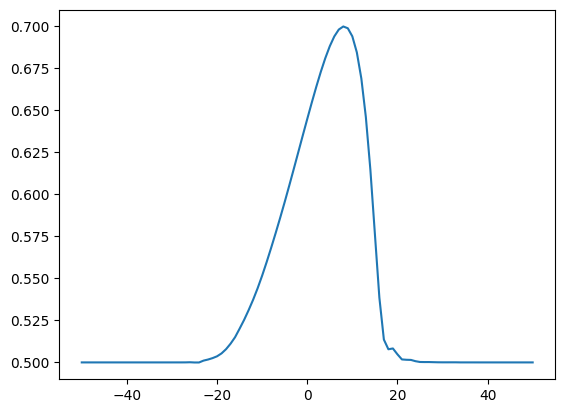

In [98]:
plt.plot(x_coordinates, grid[15, :])
plt.show()

In [100]:
print(grid[15, 65:75])

[0.57655708 0.5385072  0.51356243 0.50781054 0.50828319 0.50482802
 0.50177171 0.50156861 0.50148398 0.50072901]


The code seems to work till t = 13, after that it breaks.

In [6]:
for t in range(1, T):
#    if t == 1:
    try:
        if t == 1:
            alpha = alpha_iter(grid[t-1, :])
        elif t == 2:
            alpha = alpha_iter(two_step_vel(grid[t-1, :], grid[t-2, :]))
        else:
            alpha = alpha_iter(three_step_vel(grid[t-1, :], grid[t-2, :], grid[t-3, :]))
#        alpha = alpha_iter(1.23*np.ones(len(x_coordinates)))

        p = np.round(alpha).astype(int)
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            t_eulerian_timestep = np.where(alpha != 0, dt*(1 - p/alpha), 0)
            if w:
                for warning in w:
                    print(f"Warning at timestep {t} with message {warning.message}")
                    print(grid[t-1, :])
                    print(f"Alpha: {alpha}")
                    print(f"P: {p}")
#    elif t == 2:
#        alpha = alpha_iter(two_step_vel(grid[t-1, :], grid[t-2, :]))
#        alpha = alpha_iter(two_step_vel(1.23*np.ones(len(x_coordinates)), 1.23*np.ones(len(x_coordinates))))

#        p = np.round(alpha).astype(int)
#        t_eulerian_timestep = np.where(alpha != 0, dt*(1 - p/alpha), 0)
#    else:
#        alpha = alpha_iter(three_step_vel(grid[t-1, :], grid[t-2, :], grid[t-3, :]))
#        alpha = alpha_iter(three_step_vel(1.23*np.ones(len(x_coordinates)), 1.23*np.ones(len(x_coordinates)), 1.23*np.ones(len(x_coordinates))))

#        p = np.round(alpha).astype(int)
#        t_eulerian_timestep = np.where(alpha != 0, dt*(1 - p/alpha), 0)

        diff_grid = finite_diff(grid[t-1, :])
        double_diff_grid = finite_diff(diff_grid)
        for x in range(len(x_coordinates)):
            grid[t, x] = grid[t-1, (x - p[x])%len(x_coordinates)] - t_eulerian_timestep[(x - p[x])%len(x_coordinates)]*diff_grid[(x - p[x])%len(x_coordinates)] + 0.5*t_eulerian_timestep[(x - p[x])%len(x_coordinates)]**2*double_diff_grid[(x - p[x])%len(x_coordinates)]
        print(f"t = {t}")
    except Exception as e:
        print(e)
        print("Error at t = ", t)
        break

t = 1
t = 2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9
t = 10
t = 11
t = 12
t = 13
t = 14
t = 15
t = 16
t = 17
t = 18
t = 19
t = 20
t = 21
t = 22
t = 23
t = 24
t = 25
t = 26
t = 27
t = 28
t = 29
t = 30
t = 31
t = 32
t = 33
t = 34
t = 35
t = 36
t = 37
t = 38
t = 39
t = 40
t = 41
t = 42
t = 43
t = 44
t = 45
t = 46
t = 47
t = 48
t = 49
t = 50
t = 51
t = 52
t = 53
t = 54
t = 55
t = 56
t = 57
t = 58
t = 59
t = 60
t = 61
t = 62
t = 63
t = 64
t = 65
t = 66
t = 67
t = 68
t = 69
t = 70
t = 71
t = 72
t = 73
t = 74
t = 75
t = 76
t = 77
t = 78
t = 79
t = 80
t = 81
t = 82
t = 83
t = 84
t = 85
t = 86
t = 87
t = 88
t = 89
t = 90
t = 91
t = 92
t = 93
t = 94
t = 95
t = 96
t = 97
t = 98
t = 99


In [29]:
from video_creator_1d import create_video
create_video(grid, "check.mp4")